In [1]:
!pip install scanpy
!pip install KDEpy
!pip install leidenalg

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


# Analysis of clusters in sample S3

In [1]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums, spearmanr, kendalltau

import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.ClusterDE as cd

import importlib

## Preprocessing
### Read data

In [2]:
data_path = "../../data/MOBA_scRNAseq/outs_S1"
data_gene = sc.read_h5ad(data_path + "/filtered_data_maxpool_processed.h5ad")


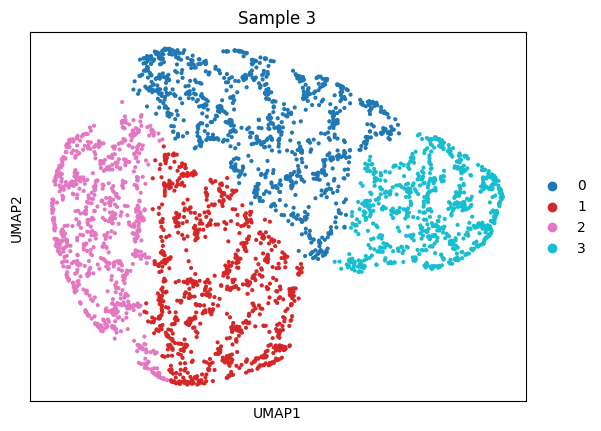

In [3]:
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

## Generate synthetic null data for ClusterDE

### Estimate distribution and parameters for every gene

In [4]:
importlib.reload(nb)
import warnings
warnings.filterwarnings("ignore")
nb.estimate_overdisp_nb(data_gene, layer="counts", flavor="statsmod_auto")


gene 0
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 100
Both NB and ZINB not converged! Using NB without starting params
gene 200
gene 300
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 400
gene 500
Both NB and ZINB not converged! Using NB without starting params
gene 600
gene 700
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 800
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
gene 900
Both NB and ZINB not converged! Using NB without starting params
Both NB and ZINB not converged! Using NB without starting params
ge

In [6]:
data_gene.var

,feature_types,genome,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,var_counts,...,dispersion_step1_sct,mean,std,gene_mean,gene_var,mean_var_diff,gene_dist,est_mean,est_overdisp,est_zero_inflation
aaeA,Gene Expression,PA01,9,0.002953,0.002949,99.734200,10.0,2.397895,9,0.003535,...,NaN,-5.832159,0.298786,0.002953,0.003535,-5.819453e-04,nb,0.002953,0.014765,0.000000
aaeB,Gene Expression,PA01,2,0.000591,0.000590,99.940933,2.0,1.098612,2,0.000590,...,NaN,-4.744446,0.118880,0.000591,0.000590,3.488880e-07,poi,0.003494,inf,0.828815
aaeR,Gene Expression,PA01,31,0.010041,0.009991,99.084465,34.0,3.555348,31,0.011713,...,NaN,-4.477485,0.422165,0.010041,0.011713,-1.671174e-03,nb,0.010031,0.052576,0.000000
aaeX,Gene Expression,PA01,7,0.002363,0.002360,99.793266,8.0,2.197225,7,0.002948,...,NaN,-5.979570,0.261760,0.002363,0.002948,-5.850852e-04,nb,0.002362,0.007920,0.000000
aas,Gene Expression,PA01,63,0.020969,0.020752,98.139398,71.0,4.276666,63,0.025254,...,0.061361,-3.722110,0.509169,0.020969,0.025254,-4.285653e-03,nb,0.020971,0.087359,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zraR,Gene Expression,PA01,27,0.008565,0.008528,99.202599,29.0,3.401197,27,0.009673,...,NaN,-4.489861,0.393549,0.008565,0.009673,-1.107981e-03,nb,0.008565,0.067938,0.000000
zraS,Gene Expression,PA01,13,0.003839,0.003832,99.616066,13.0,2.639057,13,0.003825,...,NaN,-5.603223,0.343977,0.003839,0.003825,1.474052e-05,poi,0.004799,inf,0.199960
zupT,Gene Expression,PA01,42,0.014471,0.014368,98.759598,49.0,3.912023,42,0.018397,...,NaN,-4.000824,0.435151,0.014471,0.018397,-3.925252e-03,nb,0.014473,0.042861,0.000000
zur,Gene Expression,PA01,32,0.009746,0.009699,99.054932,33.0,3.526361,32,0.010242,...,NaN,-4.478994,0.421737,0.009746,0.010242,-4.956827e-04,nb,0.009748,0.183939,0.000000


## Find optimal correlation matrix scaling and generate synthetic null data

In [21]:
importlib.reload(cd)
xmin, fval, R_est_noscale = cd.select_covariance_scaling(data_gene, cor_cutoff=0.1, min_scale=1, max_scale=2, maxiter=20, rng_seed=1234)
print(xmin)

No correlations greater than cutoff (0.1)! Skipping optimization...
1


In [22]:
importlib.reload(cd)

# Generate scaling matrix
cor_orig = cd.schaefer_strimmer(data_gene.layers["counts"].toarray(), use_corr=True)
factor_cor = (np.abs(cor_orig) > 0.1)
cf = factor_cor * xmin
cf[cf == 0] = 1
np.fill_diagonal(cf, 1)


In [23]:
importlib.reload(cd)
data_null_gen, R_est = cd.generate_nb_data_copula(data_gene, rng_seed=5678, nb_flavor="statsmod_auto",
                                                  auto_dist=True, correct_var=True, return_R=True,
                                                  corr_factor=cf, R_est=R_est_noscale, check_pd=False, min_nonzero=2)

In [24]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [25]:
data_gene_nonzero = data_gene[:, data_null_gen.var_names].copy()

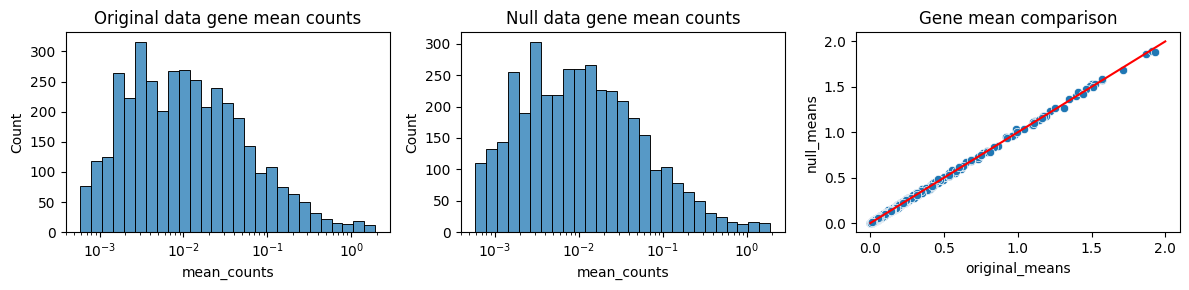

SignificanceResult(statistic=0.9846187105522926, pvalue=0.0)


In [26]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="mean_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene mean counts")
sns.histplot(data_null_gen.var, x="mean_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene mean counts")

mean_df_opt = pd.DataFrame({"original_means": data_gene_nonzero.var["mean_counts"], "null_means": data_null_gen.var["mean_counts"]})
sns.scatterplot(mean_df_opt, y="null_means", x="original_means", ax=ax[2])
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["mean_counts"]))], color="red")
ax[2].set_title("Gene mean comparison")
plt.tight_layout()
plt.show()

print(spearmanr(mean_df_opt["original_means"], mean_df_opt["null_means"]))

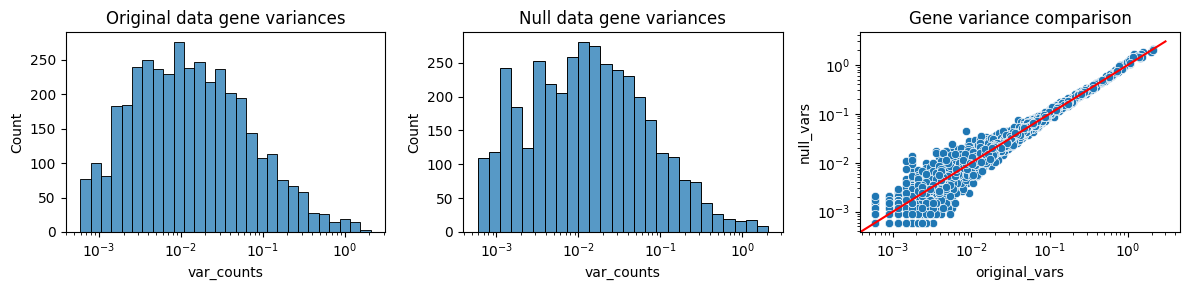

SignificanceResult(statistic=0.9753533868534472, pvalue=0.0)
[[1.         0.99523097]
 [0.99523097 1.        ]]


In [27]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene_nonzero.var, x="var_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene variances")
sns.histplot(data_null_gen.var, x="var_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene variances")

var_df_opt = pd.DataFrame({"original_vars": data_gene_nonzero.var["var_counts"], "null_vars": data_null_gen.var["var_counts"]})
var_df_opt["ratio"] = var_df_opt["null_vars"] / var_df_opt["original_vars"]
var_df_opt["diff"] = var_df_opt["null_vars"] - var_df_opt["original_vars"]

g = sns.scatterplot(var_df_opt, y="null_vars", x="original_vars", ax=ax[2])

g.set(xscale="log", yscale="log")
ax[2].plot([0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], [0, np.ceil(np.max(data_gene_nonzero.var["var_counts"]))], color="red")
ax[2].set_title("Gene variance comparison")
plt.tight_layout()
plt.show()

print(spearmanr(var_df_opt["original_vars"], var_df_opt["null_vars"]))
print(np.corrcoef(var_df_opt["original_vars"], var_df_opt["null_vars"]))

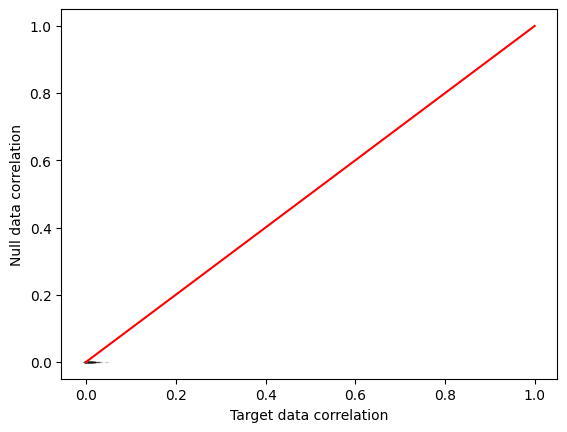

In [28]:
cor_shrink = cd.schaefer_strimmer(data_gene_nonzero.layers["counts"].toarray(), use_corr=True)
cor_shrink = pd.DataFrame(cor_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

cor_gen_shrink = cd.schaefer_strimmer(data_null_gen.X, use_corr=True)
cor_gen_shrink = pd.DataFrame(cor_gen_shrink, index=data_gene_nonzero.var_names, columns=data_gene_nonzero.var_names)

# Plot only 100.000 randomly sampled correlations instaed of ~30M
rng = np.random.default_rng(1234)
all_cors = pd.DataFrame({"cor_shrink": cor_shrink.values.flatten(), "cor_gen_shrink": cor_gen_shrink.values.flatten()})

ids = rng.choice(len(all_cors), 100000, replace=False)
all_cors_subset = all_cors.loc[ids]

sns.scatterplot(all_cors_subset[all_cors_subset['cor_shrink'] < 0.99], x="cor_shrink", y="cor_gen_shrink", s=1,
                color="black", alpha=0.1)
plt.plot([0, np.ceil(np.max(all_cors_subset['cor_shrink']))], [0, np.ceil(np.max(all_cors_subset['cor_shrink']))],
         color="red")
plt.xlabel("Target data correlation")
plt.ylabel("Null data correlation")

plt.show()

### Process null data

In [29]:
sc.pp.calculate_qc_metrics(data_null_gen)
data_null_gen.var["var_counts"] = np.asarray(np.var(data_null_gen.X, axis=0)).squeeze()
data_null_gen.var["mean_counts"] = np.asarray(np.mean(data_null_gen.X, axis=0)).squeeze()

In [30]:
importlib.reload(nb)
nb.estimate_overdisp_nb(data_null_gen, flavor="sctransform")
data_null_gen.layers["counts"] = data_null_gen.X.copy()

k_opt = data_gene.uns["BacSC_params"]["k_opt"]
n_neighbors_opt = data_gene.uns["BacSC_params"]["n_neighbors_opt"]
min_dist_opt = data_gene.uns["BacSC_params"]["min_dist_opt"]
res_opt = data_gene.uns["BacSC_params"]["res_opt"]
print(n_neighbors_opt)

sc.pp.calculate_qc_metrics(data_null_gen, var_type="genes", percent_top=None, log1p=True, inplace=True)
sc.pp.normalize_total(data_null_gen, target_sum=None, layer=None)
data_null_gen.X = sps.csr_matrix(np.log(data_null_gen.X + np.array(data_null_gen.var["nb_overdisp"] / 4)))
data_null_gen.layers["vst_counts"] = data_null_gen.X.copy()
sc.pp.scale(data_null_gen, max_value=10, zero_center=True)
data_null_gen.X[np.isnan(data_null_gen.X)] = 0
sc.tl.pca(data_null_gen, svd_solver='arpack')
sc.pp.neighbors(data_null_gen, n_neighbors=n_neighbors_opt, n_pcs=k_opt)
sc.tl.umap(data_null_gen, neighbors_key="neighbors", min_dist=min_dist_opt, spread=1)


80


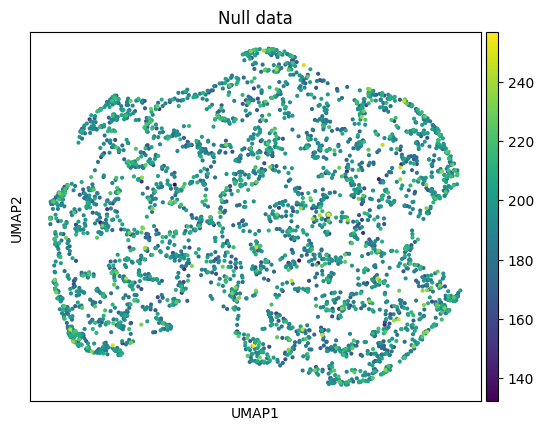

In [31]:
sc.pl.umap(data_null_gen, color="total_counts", alpha=1, cmap="viridis", title="Null data")
plt.show()


In [32]:
data_null_gen.write(data_path + "/S1_null_data_opt.h5ad")

In [33]:
res2 = 0.01
twoclust = False
#345 vs. 456

while twoclust is False:
    if (res2 * 100)%5 == 0:
        print(res2)
    res2 += 0.005
    res2 = np.round(res2, 3)
    sc.tl.leiden(data_null_gen, resolution=res2, key_added="leiden", random_state=234)
    nclust = len(data_null_gen.obs["leiden"].unique())
    if nclust == 2:
        twoclust = True
    
    
print(f"Resolution for two clusters: {res2}")

Resolution for two clusters: 0.05


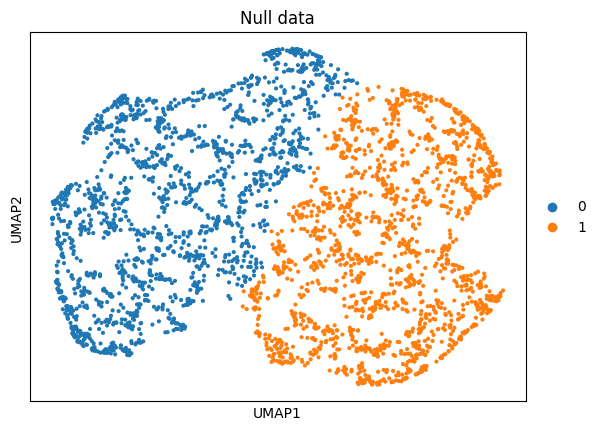

In [34]:
sc.pl.umap(data_null_gen, color="leiden", alpha=1, cmap="viridis", title="Null data")
plt.show()

In [35]:
# data_null_gen.write("../../data/MOBA_scRNAseq/outs_S3/S3_null_data_opt.h5ad")


In [36]:
X_null_gen_0 = data_null_gen.X[data_null_gen.obs["leiden"] == "0"]
X_null_gen_1 = data_null_gen.X[data_null_gen.obs["leiden"] != "0"]

pval_null_gen = pd.DataFrame({"pval_null": ranksums(X_null_gen_0, X_null_gen_1, alternative="two-sided").pvalue}, index=data_null_gen.var.index)

clusters = data_gene.obs["leiden_opt"].unique()

In [37]:
importlib.reload(cd)
DEs_log_gen = {}
pvals_log_gen = {}
fdr = 0.05

for c in clusters:
    X_data_0 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] == c].copy()
    X_data_1 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] != c].copy()
    p_data = pd.DataFrame({"pval_data": ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue}, index=data_gene_nonzero.var.index)
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=True)
    data_gene_nonzero.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene_nonzero.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene_nonzero.var[f"DE_cluster_{c}_gen"] = (data_gene_nonzero.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_log_gen[c] = DE_TU
    pvals_log_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_log_gen[c])}; Minimum q value: {np.min(pvals_log_gen[c]['q'])}")

Cluster 0 - DE genes: 0; Minimum q value: 1.0
Cluster 2 - DE genes: 41; Minimum q value: 0.038461538461538464
Cluster 3 - DE genes: 1143; Minimum q value: 0.0064516129032258064
Cluster 1 - DE genes: 0; Minimum q value: 0.6292134831460674


In [38]:
DEs_gen = {}
pvals_gen = {}
fdr = 0.05

for c in clusters:
    X_data_0 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] == c].copy()
    X_data_1 = data_gene_nonzero.X[data_gene_nonzero.obs["leiden_opt"] != c].copy()
    p_data = pd.DataFrame({"pval_data": ranksums(X_data_0, X_data_1, alternative="two-sided").pvalue}, index=data_gene_nonzero.var.index)
    DE_TU, pval_TU = cd.call_de(p_data, pval_null_gen, FDR=fdr, correct=False, nlog=False)
    data_gene_nonzero.var[f"pval_cluster_{c}_gen"] = pval_TU["pval_data"]
    data_gene_nonzero.var[f"q_cluster_{c}_gen"] = pval_TU["q"]
    data_gene_nonzero.var[f"DE_cluster_{c}_gen"] = (data_gene_nonzero.var[f"q_cluster_{c}_gen"] < fdr)
    
    DEs_gen[c] = DE_TU
    pvals_gen[c] = pval_TU
    print(f"Cluster {c} - DE genes: {len(DEs_gen[c])}; Minimum q value: {np.min(pvals_gen[c]['q'])}")

Cluster 0 - DE genes: 0; Minimum q value: 1.0
Cluster 2 - DE genes: 113; Minimum q value: 0.0136986301369863
Cluster 3 - DE genes: 1129; Minimum q value: 0.005988023952095809
Cluster 1 - DE genes: 0; Minimum q value: 0.5


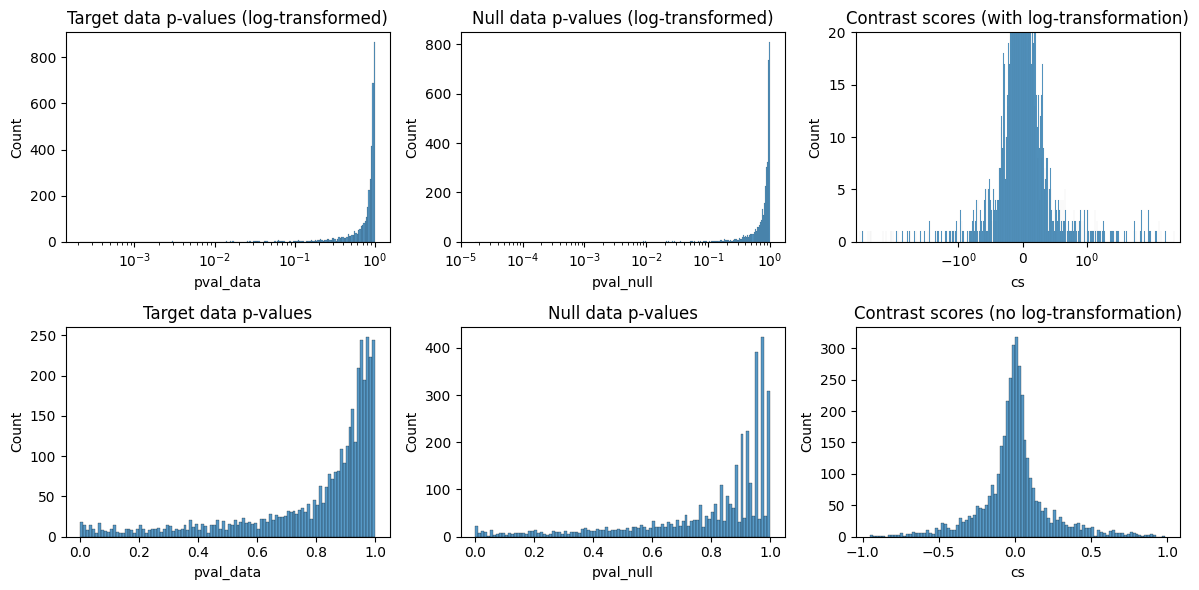

In [39]:
c = "1"

fig, ax = plt.subplots(2, 3, figsize=(12,6))
sns.histplot(pvals_log_gen[c], x="pval_data", ax=ax[0,0], log_scale=True)
ax[0,0].set_title("Target data p-values (log-transformed)")
sns.histplot(pvals_log_gen[c], x="pval_null", ax=ax[0,1], log_scale=True)
ax[0,1].set_title("Null data p-values (log-transformed)")

sns.histplot(pvals_log_gen[c], x="cs", ax=ax[0,2])
ax[0,2].set_title("Contrast scores (with log-transformation)")
ax[0,2].set(xscale="symlog",
            ylim=(0, 20)
            )

sns.histplot(pvals_gen[c], x="pval_data", ax=ax[1,0], bins=100)
ax[1,0].set_title("Target data p-values")
sns.histplot(pvals_gen[c], x="pval_null", ax=ax[1,1], bins=100)
ax[1,1].set_title("Null data p-values")

sns.histplot(pvals_gen[c], x="cs", ax=ax[1,2], bins=100)
ax[1,2].set_title("Contrast scores (no log-transformation)")


plt.tight_layout()
plt.show()

In [40]:
for c in clusters:
    print(f"cluster {c}")
    print(pvals_log_gen[c]["q"].value_counts().sort_index())
    print("")

cluster 0
1.0    3861
Name: q, dtype: int64

cluster 2
0.038462      26
0.048780      15
0.052632      16
0.061538       8
0.087500      15
            ... 
0.722750       1
0.723174       7
0.724572       4
0.725201      16
1.000000    1623
Name: q, Length: 410, dtype: int64

cluster 3
0.006452    155
0.009967    146
0.010840     68
0.012987     16
0.014141    110
           ... 
0.347446     22
0.348024      1
0.348130      2
0.348358      1
1.000000    999
Name: q, Length: 444, dtype: int64

cluster 1
0.629213      89
0.648352       2
0.663043       1
0.666667       1
0.670213       1
0.684211       1
0.701031       2
0.704082       1
0.710280       9
0.720339      11
0.722689       1
0.725000       1
0.727273       1
0.729508       1
0.758065       2
0.760000       1
0.761905       1
0.776923       4
0.798507       4
0.800000       1
0.823529       1
0.840659      46
0.848485      16
0.854271       1
0.855000       1
0.860697       1
0.864734       6
0.875000       1
0.885827      

In [41]:
pvals_log_gen[("3")]

,pval_data,pval_null,pval_trafo_data,pval_trafo_null,cs,q
fdoG,5.761051e-13,0.827031,12.239498,0.082478,12.157020,0.006452
rplX,4.589252e-14,0.051396,13.338258,1.289071,12.049188,0.006452
rpoA,7.378232e-13,0.380078,12.132048,0.420128,11.711920,0.006452
nuoF,2.450052e-11,0.281348,10.610825,0.550756,10.060068,0.006452
rplN,2.690241e-11,0.212724,10.570209,0.672184,9.898025,0.006452
...,...,...,...,...,...,...
rpsM,7.980678e-01,0.023064,0.097960,1.637067,-1.539106,1.000000
rpsD,2.019059e-01,0.004645,0.694851,2.332969,-1.638118,1.000000
gatB,5.507019e-02,0.000595,1.259083,3.225357,-1.966274,1.000000
rpsA,2.369147e-01,0.000077,0.625408,4.111666,-3.486258,1.000000
